In [157]:
import time
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup, element

from selenium.common.exceptions import NoSuchElementException

### Gratka

In [8]:
def gratka_df(city:str, num_of_pages:int):
    ### 1 Step
    # Opening Google
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    # Direct to predefine website
    driver.get('https://gratka.pl/')

    ### 1.5 Step
    # Accespting cookies
    time.sleep(2)
    cookie = driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div[2]/div/div[6]/button[2]')
    cookie.click()
    time.sleep(1)

    ### 2 Step
    ## Navigate to real-estate
    real_estates = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[1]/div[2]/ul/li[1]/a')
    real_estates.click()
    # All categories
    all_estates = driver.find_element(By.XPATH, '/html/body/div/div[2]/div[1]/div[2]/ul/li[2]/ul/li[8]/a')
    all_estates.click()
    # location
    loc_bar = driver.find_element(By.XPATH, '/html/body/div[2]/div/div/div/div/div/div/div[2]/div/div/div[1]/input')
    loc_bar.send_keys(city) #variable
    time.sleep(2)
    loc_bar.send_keys(Keys.ENTER)

    ### 2.5 Step
    ## Search
    search = driver.find_element(By.XPATH, '/html/body/div[2]/div/div/div/div/div/div/div[9]/div')
    search.click()
    time.sleep(2)
    search = driver.find_element(By.XPATH, '/html/body/div[2]/div/div/div/div/div/div/div[9]/div')
    search.click()
    time.sleep(2)

    ### 4 Iterate through houses
    soup = BeautifulSoup(driver.page_source)
    houses = list()
    df_gratka = pd.DataFrame()

    # retriving info about number of pages
    max_pages = int(soup.find('div', {'class':'pagination container'}).text.replace('\n','').split('z')[-1])

    if num_of_pages < max_pages:
        x = num_of_pages
    else:
        x = max_pages

    for i in range(0,x):
        # dealing with alerts popouts
        try:
            time.sleep(2)
            driver.find_element(By.XPATH, '/html/body/div[4]/div/div[2]/div[1]/div[1]/div/button').click() 
        except NoSuchElementException:
            pass

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        properties = soup.find_all('div', {'class': 'listing__teaserWrapper'})
        for proper in properties:
            houses.append({
                'name': proper.find('h2',{'class':'teaserUnified__title'}).text.split('\n')[1],
                'city': proper.find('span', {'class': 'teaserUnified__location'}).text.split(',')[0].replace(' ','').replace('\n',''),
                'price' : proper.find('p', {'class': 'teaserUnified__price'}).text.split('\n')[1],
                'area' : proper.find('li', {'class': 'teaserUnified__listItem'}).text,
                'price_per_m2' : (proper.find('span', {'class': 'teaserUnified__additionalPrice'})).text.split('\n')[1],
                'link': proper.find('a', {'class': 'teaserLink'}).get('href'),
                #'District':  proper.find('span', {'class': 'teaserUnified__location'}).text.split(',')[1].replace(' ',''),
                #'Street': proper.find('h2', {'class': 'teaserUnified__title'}).text.split(',')[-1].replace('\n',''),
                })
        df = pd.DataFrame(houses)

        additions = list()
        for x in range(len(df['link'])):
            url = df['link'][x]
            res = requests.get(url)
            soup = BeautifulSoup(res.text, 'html.parser')
            try:
                forma_wlasnosci = soup.find_all('b', {'class': 'parameters__value'})[4].text
            except:
                forma_wlasnosci = np.nan             
            try:
                stan_wykonczenia = soup.find('b', {'class': 'parameters__value'}).find_all('li')[3].text
            except:
                stan_wykonczenia = np.nan               
            try:
                pietro = soup.find_all('b', {'class': 'parameters__value'})[3].text
            except:
                pietro = np.nan      
            try:
                parking = soup.find_all('b', {'class': 'parameters__value'})[7].text
            except:
                parking = np.nan
            try:
                rooms = soup.find_all('b', {'class': 'parameters__value'})[2].text
            except:
                rooms = np.nan
                        
            additions.append({
                'forma_wlasnosci': forma_wlasnosci,
                'stan_wykonczenia': stan_wykonczenia,
                'pietro': pietro,
                'parking': parking,
                'rooms': rooms,
                'balkon':np.nan,	
                'czynsz':np.nan,	
                'ogrzewanie':np.nan
                })
            
        df = df.join(pd.DataFrame(additions))
        df_gratka = df_gratka.append(df)

        if i == 0:   
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(5)
            driver.find_element(By.XPATH, '/html/body/div[3]/div[2]/div[1]/div[42]/a[6]').click()
        elif i > 0 and i+1 < x:
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(5)
            driver.find_element(By.XPATH, '/html/body/div[3]/div[2]/div[1]/div[42]/a[7]').click()
        else:
            break
                
    driver.quit()
    df_gratka_v2 = df_gratka.drop_duplicates()
    return df_gratka_v2

In [166]:
def main_fun(city, page_num):
    # Get the HTML from the page
    url = 'https://www.otodom.pl'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    # search input
    key = city
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    time.sleep(2)
    # full screen window 
    driver.maximize_window()
    #cookie click
    cookie_click = driver.find_element(By.XPATH, '//*[@id="onetrust-accept-btn-handler"]')
    cookie_click.click()
    time.sleep(2)
    #search bar click
    search_bar = driver.find_element(By.XPATH, '//*[@id="location"]/div[2]')
    search_bar.click()
    time.sleep(2)
    #search entry
    search_entry = driver.find_element(By.XPATH, '//*[@id="location-picker-input"]')
    search_entry.send_keys(key)
    time.sleep(2)
    #search select
    search_select = driver.find_element(By.XPATH, '//*[@id="__next"]/main/section/div/div/form/div/div[1]/div[3]/div/div[1]/div/div[2]/ul/li[1]/label[1]')
    search_select.click()
    time.sleep(2)
    #search button press
    search_button = driver.find_element(By.XPATH, '//*[@id="search-form-submit"]')
    search_button.click()
    time.sleep(5)
    # getting apartments data    
    url = driver.current_url 
    res = requests.get(url)
    time.sleep(2)
    # 72 per page    
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div').click()
    time.sleep(4)
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div[2]/div/div[4]').click() 
    time.sleep(4)
    df_otodom = pd.DataFrame()

    soup_v0 = BeautifulSoup(driver.page_source, 'html.parser')

    if '...' in soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text:
        max_page = soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text.split('...')[-1]
    else:
        max_page = soup_v0.find('nav', {'class':'css-geek62 eo9qioj0'}).text[-1]
        
    max_page = int(max_page)

    if page_num < max_page:
        x = page_num
    else:
        x = max_page

    j = 3

    for i in range(0, x):
        if i != x:      
               # scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                # getting apartments data
                url = driver.current_url
                res = requests.get(url)
                time.sleep(3)
                ##scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                apartment = soup.find_all('li', {'class': 'css-iq9jxc e1n6ljqa1'})
                apt: element.Tag
                apartments = list()
                for apt in apartment:
                    try:
                        apartments.append({
                            'name': apt.find('h3', {'class': 'css-1mmyqk7 e1n6ljqa6'}).text,
                            'city': key,
                            'price': apt.find('span', {'class': 'css-1ntk0hg ei6hyam1'}).text,
                            'rooms': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[2].get_text(),
                            'area': (apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[3].get_text()),
                            'price_per_m2': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[1].get_text(),
                            'link': url + apt.find('a', {'class': 'css-1up0y1q e1n6ljqa16'}).get('href')
                        })
                    except:
                        pass
                df = pd.DataFrame(apartments)
                
                links = df['link'].tolist()
                good_links = list()
                for i in range(len(links)):
                    url = links[i]
                    prefix = 'https://www.otodom.pl'
                    suffix = url.split('/oferta/')[-1]
                    result = prefix + '/oferta/' + suffix
                    good_links.append(result)

                # replace df link column with good_links
                df['link'] = good_links
                
                additions = list()
                for x in range(len(df['link'])):
                    url = df['link'][x]
                    res = requests.get(url)
                    soup = BeautifulSoup(res.text, 'html.parser')
                    try:
                        forma_wlasnosci = soup.find('div', {'aria-label': 'Forma własności'}).find_all('div')[3].text
                    except:
                        forma_wlasnosci = np.nan
                        
                    try:
                        stan_wykonczenia = soup.find('div', {'aria-label': 'Stan wykończenia'}).find_all('div')[3].text
                    except:
                        stan_wykonczenia = np.nan
                        
                    try:
                        pietro = soup.find('div', {'aria-label': 'Piętro'}).find_all('div')[3].text
                    except:
                        pietro = np.nan
                        
                    try:
                        balkon = soup.find('div', {'aria-label': 'Balkon / ogród / taras'}).find_all('div')[3].text
                    except:
                        balkon = np.nan
                        
                    try:
                        czynsz = soup.find('div', {'aria-label': 'Czynsz'}).find_all('div')[3].text
                    except:
                        czynsz = np.nan
                    
                    try:
                        parking = soup.find('div', {'aria-label': 'Miejsce parkingowe'}).find_all('div')[3].text
                    except:
                        parking = np.nan
                        
                    try:
                        ogrzewanie = soup.find('div', {'aria-label': 'Ogrzewanie'}).find_all('div')[3].text
                    except:
                        ogrzewanie = np.nan
                    
                    additions.append({
                    'forma_wlasnosci': forma_wlasnosci,
                    'stan_wykonczenia': stan_wykonczenia,
                    'pietro': pietro,
                    'balkon': balkon,
                    'czynsz': czynsz,
                    'parking': parking,
                    'ogrzewanie': ogrzewanie
                    })
                df = df.join(pd.DataFrame(additions))
                df_otodom = df_otodom.append(df)

                # scroll to top                                   
                driver.execute_script("window.scrollTo(document.body.scrollHeight,0);")
                time.sleep(2)

                if j < 6:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[{j}]').click()           
                    time.sleep(3)
                    j = j+1
                else:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[7]').click()
                    time.sleep(3)
                continue
        else:
            break
    
    df_otodom.drop_duplicates(subset=['name', 'link'], inplace=True)
    df_otodom.reset_index(drop=True, inplace=True)

    insights = pd.DataFrame(index = df_otodom.index, columns= df_otodom.columns)
    for i in range(0,len(df_otodom)):
        # Name
        insights['name'] = df_otodom['name']
        # Price Columns
        insights['price'][i] = df_otodom['price'][i].replace('\xa0','').split('z')[0]
        insights['price'][i] = insights['price'][i].replace('Zapytaj o cenę','')
        insights['price'][i] = insights['price'][i].replace(',','.')

        # Rooms
        insights['rooms'][i] = df_otodom.rooms[i].split(' ')[0]
        # Area
        insights['area'][i] = df_otodom.area[i].split(' ')[0]
        # Sqm price
        insights['price_per_m2'][i] = df_otodom['price_per_m2'][i].replace('\xa0','').split('z')[0]
        # Czynsz columns
        if df_otodom['czynsz'][i] is np.nan:
            insights['czynsz'][i] = ''
        else:
            insights['czynsz'][i] = df_otodom['czynsz'][i].split(' z')[0]
            insights['czynsz'][i] = insights['czynsz'][i].replace(' ','')
            insights['czynsz'][i] = insights['czynsz'][i].replace(',','.')
        # Link
        insights['link'][i] = df_otodom['link'][i]
        # Forma Wlasnosci
        insights['forma_wlasnosci'][i] = df_otodom['forma_wlasnosci'][i]
        # Balkon
        insights['balkon'][i] = df_otodom['balkon'][i]
        # Parking
        insights['parking'][i] = df_otodom['parking'][i]
        # Ogrzewanie
        insights['ogrzewanie'][i] = df_otodom['ogrzewanie'][i]
        # city
        insights['city'][i] = df_otodom['city'][i]
    

    df_gratka = gratka_df(city,page_num)
    for row in range(0,len(df_gratka)):
        df_gratka.price[row] = df_gratka.price[row].replace(' ','').replace('zł','')
        df_gratka.area[row] = df_gratka.area[row].split(' ')[0].replace(',','.')
        df_gratka.price_per_m2[row] = df_gratka.price_per_m2[0].split('z')[0].replace(' ','')

    insights = insights.append(df_gratka)
    return insights

In [167]:
otodom_main = main_fun('Przemyśl', 2)

[WDM] - Downloading: 100%|██████████| 6.79M/6.79M [00:00<00:00, 15.5MB/s]
C:\Users\WT719\AppData\Local\Temp\ipykernel_26616\3184984474.py:153: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\WT719\AppData\Local\Temp\ipykernel_26616\3184984474.py:153: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\WT719\AppData\Local\Temp\ipykernel_26616\3819867772.py:111: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gratka = df_gratka.append(df)
C:\Users\WT719\AppData\Local\Temp\ipykernel_26616\3819867772.py:111: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gratka =

In [159]:
df_v2 = otodom_main.copy()

In [160]:
df_v2.reset_index(drop=True, inplace=True)

In [161]:
for i in range(0, len(df_v2)):
    if df_v2.forma_wlasnosci[i] == "spółdzielcze własnościowe" or df_v2.forma_wlasnosci[i] == "pełna własność" or df_v2.forma_wlasnosci[i] == "własność":
        pass
    else:
        df_v2.forma_wlasnosci[i] = np.nan

    if df_v2.parking[i] == "garaż/miejsce parkingowe" or df_v2.parking[i] == "w drodze" or df_v2.parking[i] == "tak":
        pass
    else:
        df_v2.parking[i] = np.nan

    if df_v2.rooms[i] == "1" or df_v2.rooms[i] == "2" or df_v2.rooms[i] == "3" or df_v2.rooms[i] == "4" or df_v2.rooms[i] == "5" or df_v2.rooms[i] == "6" or df_v2.rooms[i] == "7" or df_v2.rooms[i] == "8" or df_v2.rooms[i] == "9" or df_v2.rooms[i] == "10":
        pass
    else:
        df_v2.rooms[i] = np.nan

    if df_v2.pietro[i] == "1" or df_v2.pietro[i] == "2" or df_v2.pietro[i] == "3" or df_v2.pietro[i] == "4" or df_v2.pietro[i] == "5" or df_v2.pietro[i] == "6" or df_v2.pietro[i] == "7" or df_v2.pietro[i] == "8" or df_v2.pietro[i] == "9" or df_v2.pietro[i] == "10":
        pass
    else:
        df_v2.pietro[i] = np.nan

    if df_v2.czynsz[i] == "":
        df_v2.czynsz[i] = np.nan
    else:
        pass

    if df_v2.price_per_m2[i] == '':
        df_v2.price_per_m2[i] = np.nan

    if df_v2.price[i] == '':
        df_v2.price[i] = np.nan

In [165]:
df_v2.tail(40)

,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
130,Mieszkanie Przemyśl,Przemyśl,290000,3,60.30,244,https://gratka.pl/nieruchomosci/mieszkanie-prz...,spółdzielcze własnościowe,None,2,None,None,NaN,None
131,Mieszkanie Przemyśl,Przemyśl,249000,3,53.30,244,https://gratka.pl/nieruchomosci/mieszkanie-prz...,NaN,None,2,None,None,NaN,None
132,Mieszkanie Przemyśl,Przemyśl,310000,2,48,244,https://gratka.pl/nieruchomosci/mieszkanie-prz...,NaN,None,4,None,None,NaN,None
133,"Działka usługowa Przemyśl, ul. Monte Cas...",Przemyśl,790000,NaN,4,244,https://gratka.pl/nieruchomosci/dzialka-uslugo...,NaN,None,NaN,None,None,NaN,None
134,"Mieszkanie Przemyśl, ul. Skorupki",Przemyśl,799000,3,102,244,https://gratka.pl/nieruchomosci/mieszkanie-prz...,własność,None,3,None,None,NaN,None
135,"Lokal Przemyśl, ul. Herburtów",Przemyśl,420000,NaN,150,244,https://gratka.pl/nieruchomosci/lokal-przemysl...,NaN,None,NaN,None,None,NaN,None
136,"Mieszkanie Przemyśl, ul. Armii Krajowej",Przemyśl,448650,2,59.82,244,https://gratka.pl/nieruchomosci/mieszkanie-prz...,NaN,None,3,None,None,NaN,None
137,"Mieszkanie Przemyśl, ul. Armii Krajowej",Przemyśl,320850,2,42.78,244,https://gratka.pl/nieruchomosci/mieszkanie-prz...,NaN,None,3,None,None,NaN,None
138,"Mieszkanie Przemyśl, ul. Armii Krajowej",Przemyśl,261755,2,40.27,244,https://gratka.pl/nieruchomosci/mieszkanie-prz...,NaN,None,2,None,None,NaN,None
139,"Mieszkanie Przemyśl, ul. Popielów",Przemyśl,350000,3,65,244,https://gratka.pl/nieruchomosci/mieszkanie-prz...,własność,None,NaN,None,None,NaN,None


In [143]:
colch = {'price', 'area', 'price_per_m2', 'czynsz', 'pietro', 'rooms'}

for col in colch:
    insights[col] = pd.to_numeric(insights[col])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "pandas\_libs\lib.pyx", line 2369, in pandas._libs.lib.maybe_convert_numeric
ValueError: Unable to parse string "brak"

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\WT719\Anaconda3\envs\web_scrap\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\WT719\AppData\Local\Temp\ipykernel_26616\4025011670.py", line 4, in <module>
    insights[col] = pd.to_numeric(insights[col])
  File "c:\Users\WT719\Anaconda3\envs\web_scrap\lib\site-packages\pandas\core\tools\numeric.py", line 185, in to_numeric
    values, _ = lib.maybe_convert_numeric(
  File "pandas\_libs\lib.pyx", line 2411, in pandas._libs.lib.maybe_convert_numeric
ValueError: Unable to parse string "brak" at position 121

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  

C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\197080933.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insights['price_per_m2'], bins=50, kde=False)


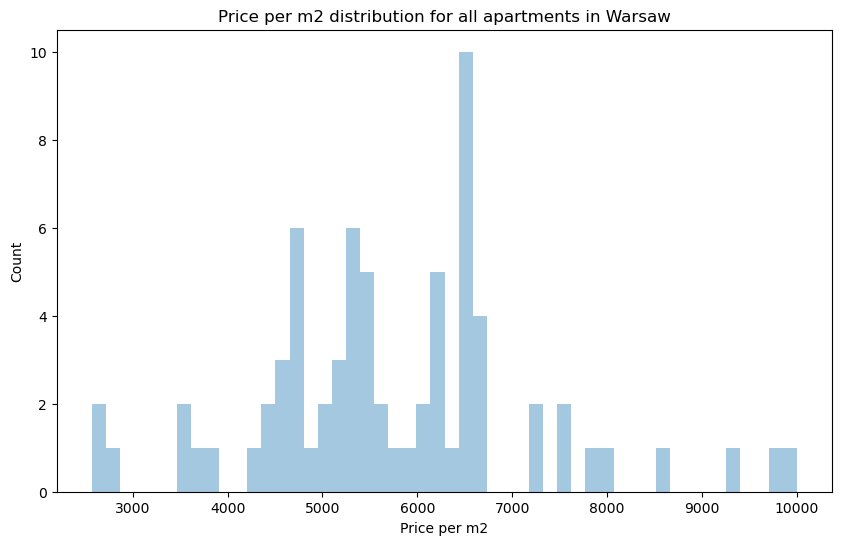

In [220]:
# plot price per m2 distribution for all apartments in Warsaw 
plt.figure(figsize=(10, 6))
sns.distplot(insights['price_per_m2'], bins=50, kde=False)
plt.title('Price per m2 distribution for all apartments in Warsaw')
plt.xlabel('Price per m2')
plt.ylabel('Count')
plt.show()

In [162]:
df_v2['price_per_m2'].dropna()

0      6109
1      4442
2      6569
3      3715
4      4800
       ... 
165     244
166     244
167     244
168     244
169     244
Name: price_per_m2, Length: 136, dtype: object

C:\Users\WT719\AppData\Local\Temp\ipykernel_26616\3835696481.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_v2['price_per_m2'].dropna(), bins=50, kde=False)


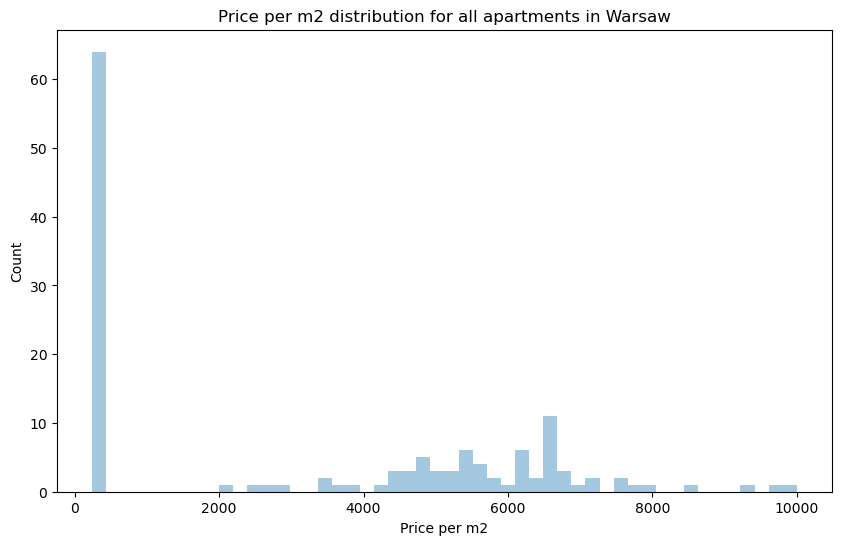

In [163]:
# plot price per m2 distribution for all apartments in Warsaw 
plt.figure(figsize=(10, 6))
sns.distplot(df_v2['price_per_m2'].dropna(), bins=50, kde=False)
plt.title('Price per m2 distribution for all apartments in Warsaw')
plt.xlabel('Price per m2')
plt.ylabel('Count')
plt.show()

C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\946159346.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insights['price'], bins=50, kde=False)


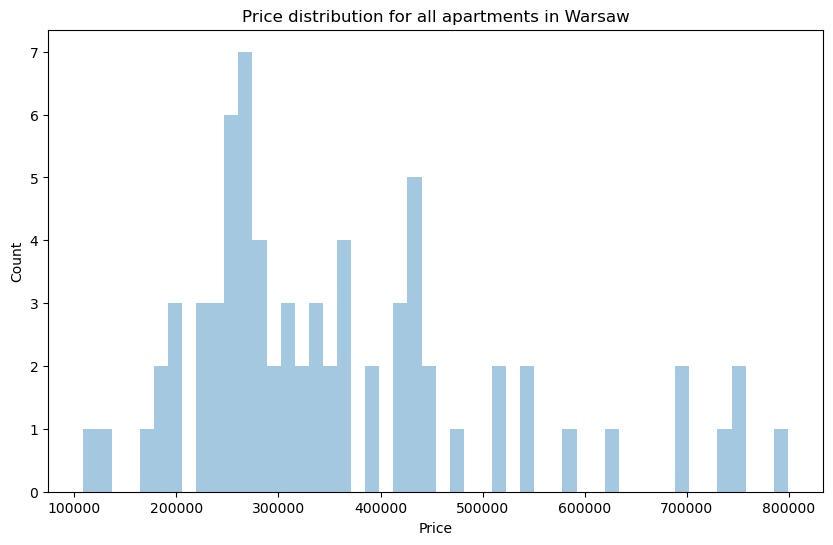

In [221]:
# plot price for all apartments in Warsaw and show price true values on xlabel
plt.figure(figsize=(10, 6))
sns.distplot(otodom_main['price'], bins=50, kde=False)
plt.title('Price distribution for all apartments in Warsaw')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

C:\Users\WT719\AppData\Local\Temp\ipykernel_26616\3484440180.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'], bins=50, kde=False)


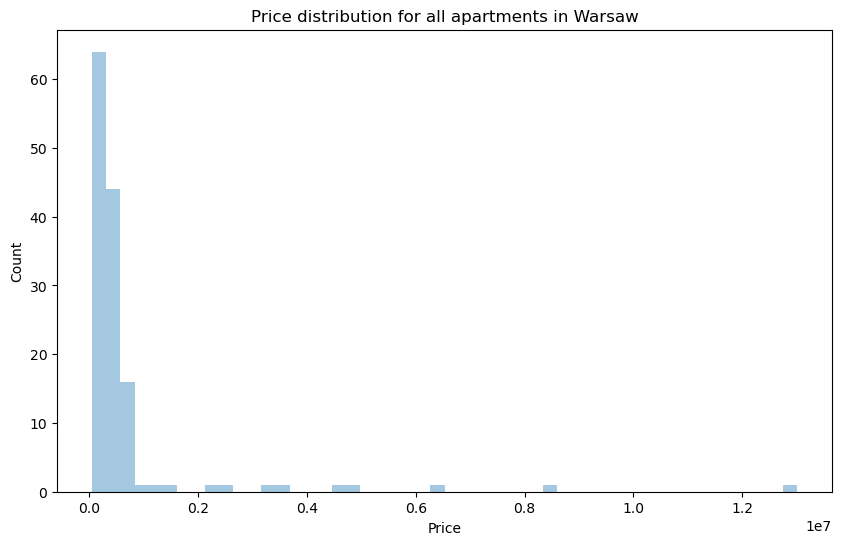

In [151]:
# plot price for all apartments in Warsaw and show price true values on xlabel
plt.figure(figsize=(10, 6))
sns.distplot(df['price'], bins=50, kde=False)
plt.title('Price distribution for all apartments in Warsaw')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

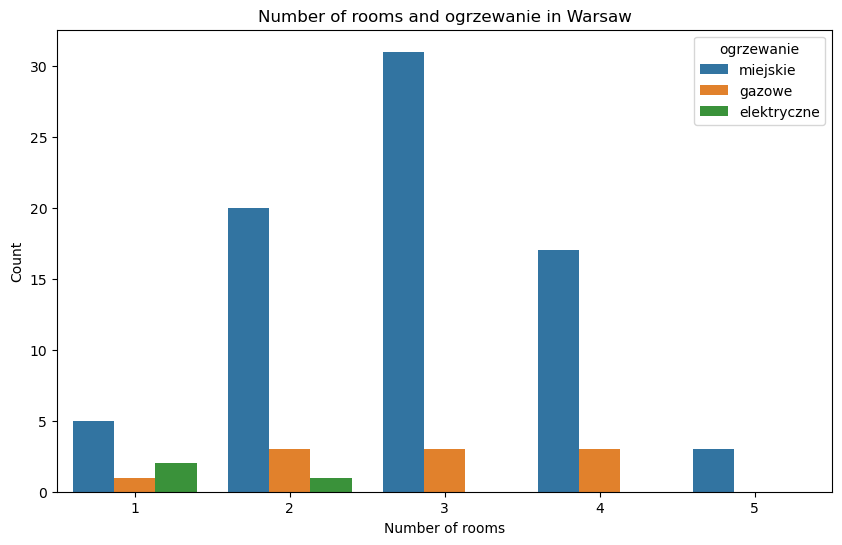

In [222]:
# compare number of rooms and ogrzewanie in Warsaw
plt.figure(figsize=(10, 6))
sns.countplot(x='rooms', hue='ogrzewanie', data=insights)
plt.title('Number of rooms and ogrzewanie in Warsaw')
plt.xlabel('Number of rooms')
plt.ylabel('Count')
plt.show()

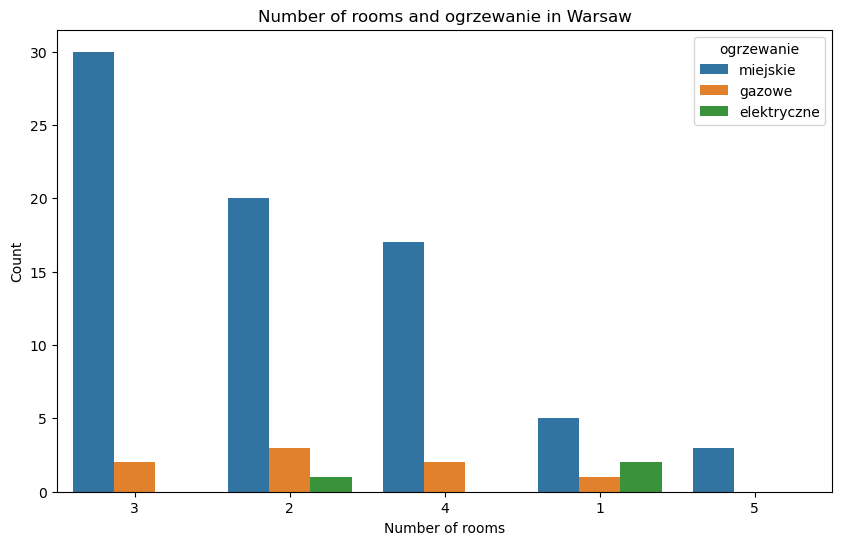

In [152]:
# compare number of rooms and ogrzewanie in Warsaw
plt.figure(figsize=(10, 6))
sns.countplot(x='rooms', hue='ogrzewanie', data=df)
plt.title('Number of rooms and ogrzewanie in Warsaw')
plt.xlabel('Number of rooms')
plt.ylabel('Count')
plt.show()